In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')


In [56]:
df = pd.read_csv('loan.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


To see the shape of the dataset, we can use shape method.

In [57]:
df.shape

(614, 13)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


To get values like the mean, count and min of the column we can use describe() method.

In [59]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


# Exploratory Data Analysis

EDA refers to the detailed analysis of the dataset which uses plots like distplot, barplots, etc.

Let’s start by plotting the piechart for LoanStatus column.

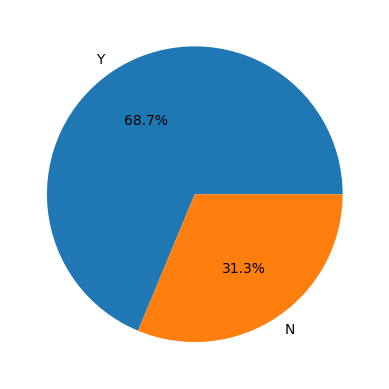

In [60]:
temp = df['Loan_Status'].value_counts()
plt.pie(temp.values,
        labels=temp.index,
        autopct='%1.1f%%')
plt.show()


Here we have an imbalanced dataset. We will have to balance it before training any model on this data.

We specify the DataFrame df as the data source for the sb.countplot() function. The x parameter is set to the column name from which the count plot is to be created, and hue is set to ‘Loan_Status’ to create count bars based on the ‘Loan_Status’ categories.

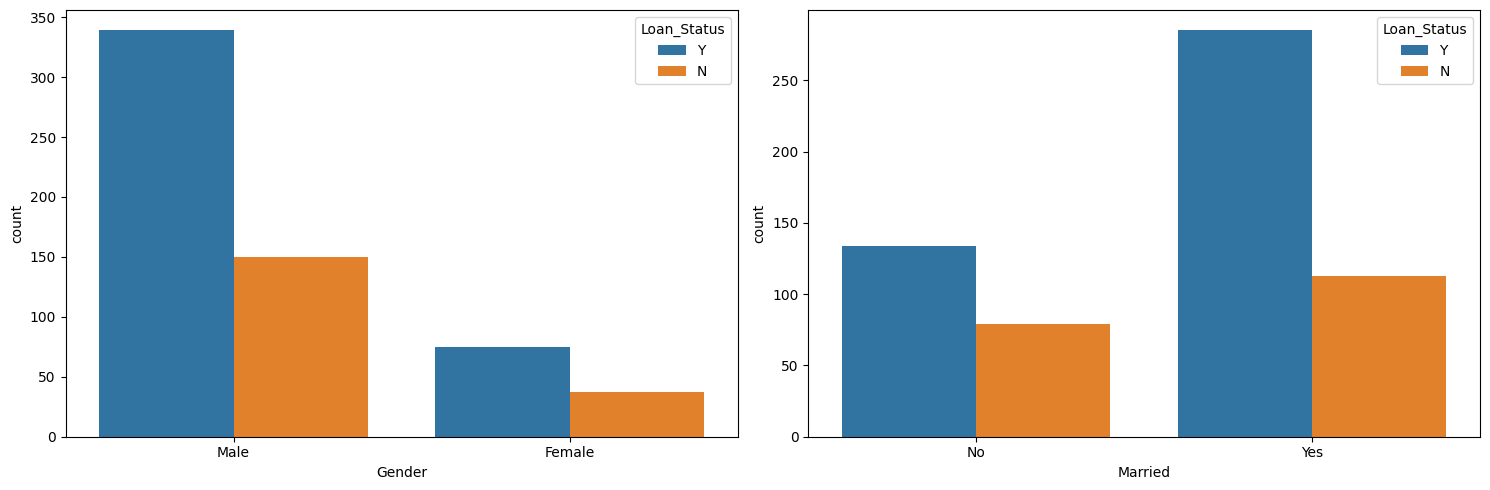

In [61]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['Gender', 'Married']):
    plt.subplot(1, 2, i+1)
    sb.countplot(data=df, x=col, hue='Loan_Status')
plt.tight_layout()
plt.show()


One of the main observations we can draw here is that the chances of getting a loan approved for married people are quite low compared to those who are not married.

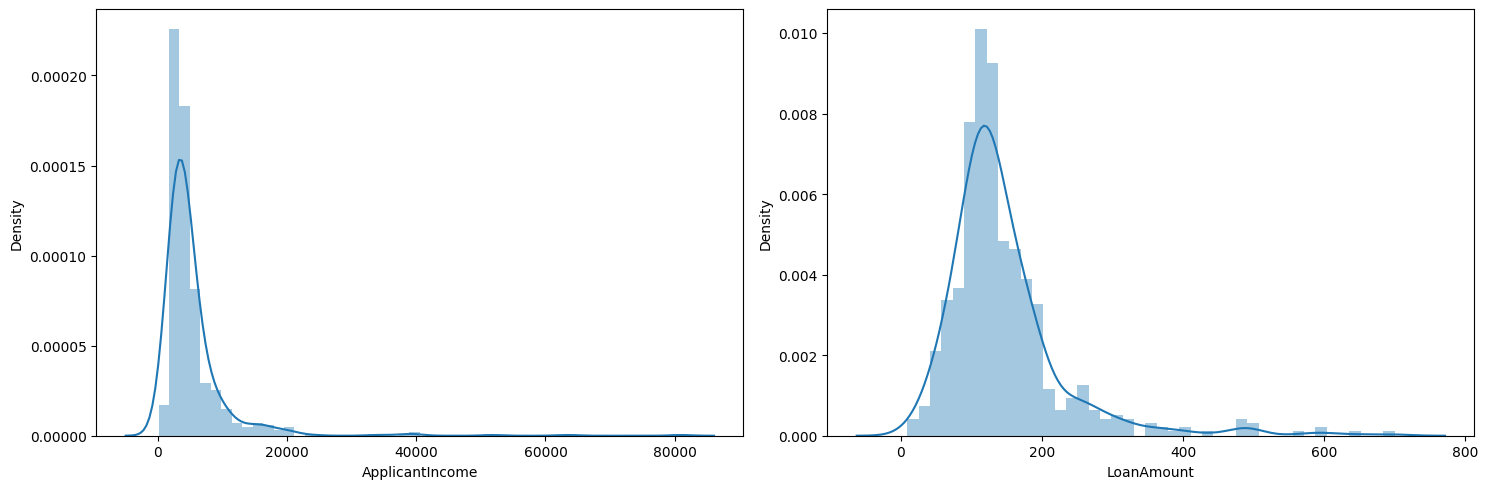

In [62]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['ApplicantIncome', 'LoanAmount']):
    plt.subplot(1, 2, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()


To find out the outliers in the columns, we can use boxplot.

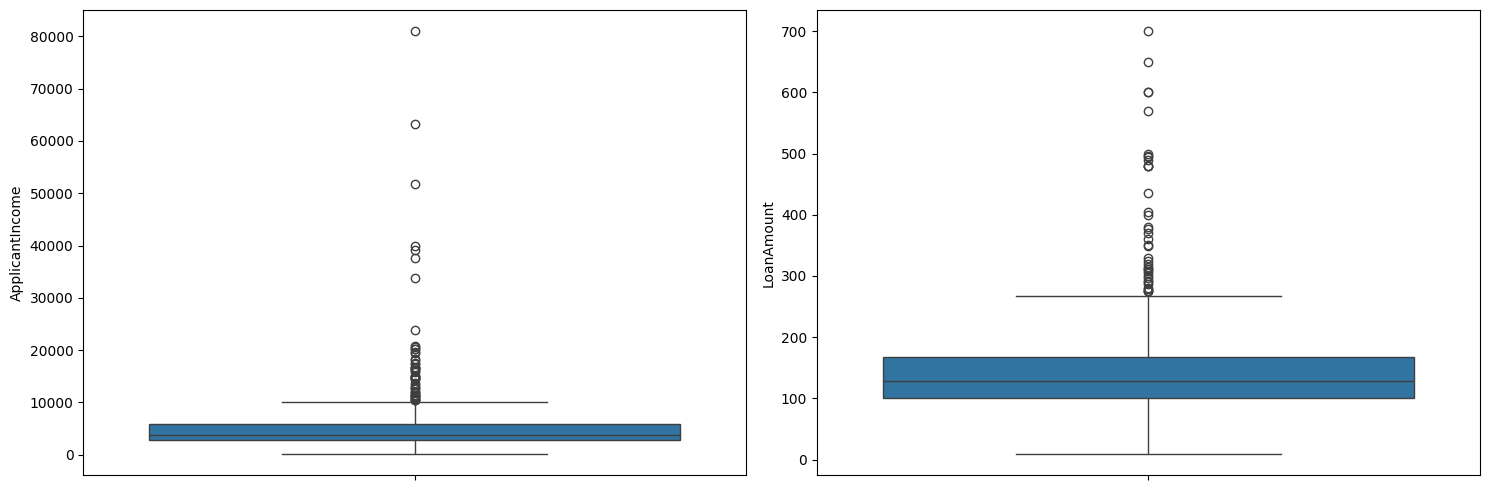

In [63]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(['ApplicantIncome', 'LoanAmount']):
    plt.subplot(1, 2, i+1)
    sb.boxplot(df[col])
plt.tight_layout()
plt.show()


There are some extreme outlier’s in the data we need to remove them.

In [64]:
df = df[df['ApplicantIncome'] < 25000]
df = df[df['LoanAmount'] < 400000]


Let’s see the mean amount of the loan granted to males as well as females. For that, we will use groupyby() method.

In [65]:
df.groupby('Gender').mean(numeric_only=True)['LoanAmount']

# This code is modified by Susobhan Akhuli


,LoanAmount
Gender,
Female,126.697248
Male,146.924569


The loan amount requested by males is higher than what is requested by females.

In [71]:
df.groupby(['Married', 'Gender']).mean(numeric_only=True)['LoanAmount']

# This code is modified by Susobhan Akhuli


Married  Gender
0        0         116.115385
         1         135.959677
         2         160.666667
1        0         153.322581
         1         150.875740
         2         169.888889
2        1         159.000000
Name: LoanAmount, dtype: float64

Here is one more interesting observation in addition to the previous one that the married people requested loan amount is generally higher than that of the unmarried. This may be one of the reason’s that we observe earlier that the chances of getting loan approval for a married person are lower than that compared to an unmarried person.

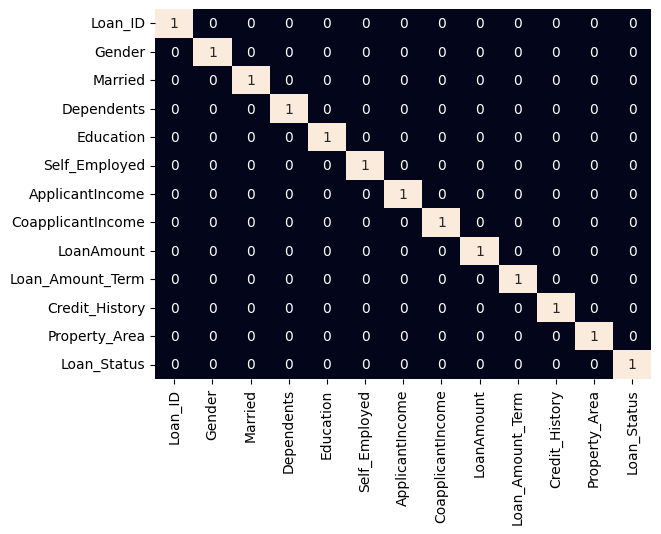

In [72]:
# Function to apply label encoding
def encode_labels(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])

    return data

# Applying function in whole column
df = encode_labels(df)

# Generating Heatmap
sb.heatmap(df.corr() > 0.8, annot=True, cbar=False)
plt.show()


# Data Preprocessing

In this step, we will split the data for training and testing. After that, we will preprocess the training data.

In [73]:
features = df.drop('Loan_Status', axis=1)
target = df['Loan_Status'].values

X_train, X_val,    Y_train, Y_val = train_test_split(features, target,
                                    test_size=0.2,
                                    random_state=10)

# As the data was highly imbalanced we will balance
# it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)

X_train.shape, X.shape


((468, 12), (666, 12))

We will now use Standard scaling for normalizing the data.

In [74]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)


# Model Development

We will use Support Vector Classifier for training the model.

In [79]:
# Normalizing the features for stable and fast training.
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

# Create an imputer object with a strategy (e.g., mean)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your training data and transform both training and validation data
X = imputer.fit_transform(X)
X_val = imputer.transform(X_val)

# Now scale the data after imputation
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

# Rest of your code for model training and evaluation
model = SVC(kernel='rbf')
model.fit(X, Y)

print('Training Accuracy : ', metrics.roc_auc_score(Y, model.predict(X)))
print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, model.predict(X_val)))
print()

Training Accuracy :  0.8738738738738738
Validation Accuracy :  0.6223536737235367



# Model Evaluation

Model Evaluation can be done using confusion matrix.

we first train the SVC model using the training data X and Y. Then, we calculate the ROC AUC scores for both the training and validation datasets. The confusion matrix is built for the validation data by using the confusion_matrix function from sklearn.metrics. Finally, we plot the confusion matrix using the plot_confusion_matrix function from the sklearn.metrics.plot_confusion_matrix submodule.

In [80]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
training_roc_auc = roc_auc_score(Y, model.predict(X))
validation_roc_auc = roc_auc_score(Y_val, model.predict(X_val))
print('Training ROC AUC Score:', training_roc_auc)
print('Validation ROC AUC Score:', validation_roc_auc)
print()
cm = confusion_matrix(Y_val, model.predict(X_val))


Training ROC AUC Score: 0.8738738738738738
Validation ROC AUC Score: 0.6223536737235367



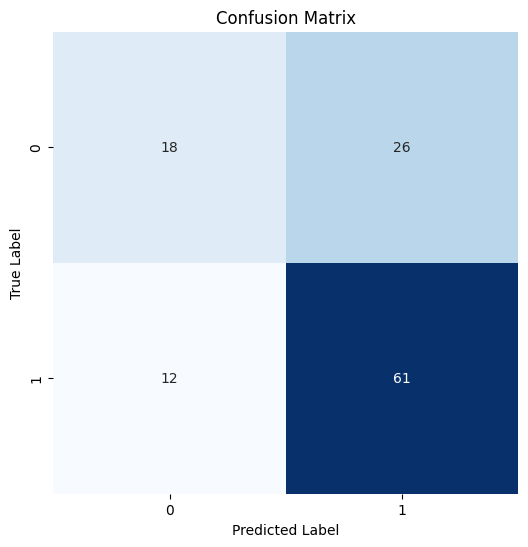

In [81]:
plt.figure(figsize=(6, 6))
sb.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [82]:
from sklearn.metrics import classification_report
print(classification_report(Y_val, model.predict(X_val)))

              precision    recall  f1-score   support

           0       0.60      0.41      0.49        44
           1       0.70      0.84      0.76        73

    accuracy                           0.68       117
   macro avg       0.65      0.62      0.62       117
weighted avg       0.66      0.68      0.66       117



Conclusion
As this dataset contains fewer features the performance of the model is not up to the mark maybe if we will use a better and big dataset we will be able to achieve better accuracy.